In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.style.use("seaborn-white")
import seaborn as sns
sns.set_style("white")
from sklearn.model_selection import train_test_split
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils import data
import logging
import random
from tensorboardX import SummaryWriter
from tqdm import tqdm
import torch.nn as nn
from collections import defaultdict

In [ ]:
from data import prepare_data, TGSSaltDataset
from model import model_path, save_checkpoint, update_state, predict_tta
from resnetlike import UNetResNet
from training import train, test, RefineStep
from utils import tboard_log_path
from losses import lovasz_hinge
from metrics import my_iou_metric, iou_metric_batch
from visualisation import plot_poor_predictions, plot_predictions
from config import load_config, save_config


In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
now = datetime.datetime.now()

In [ ]:
config = load_config()["RefineModel"]
logger.info(f"Loading config {config}")

In [6]:
locals().update(config)

In [ ]:
torch.backends.cudnn.benchmark = True
logger.info(f"Started {now}")
tboard_log = os.path.join(tboard_log_path(), f"log_{id}")
logger.info(f"Writing TensorBoard logs to {tboard_log}")
summary_writer = SummaryWriter(log_dir=tboard_log)

In [9]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [10]:
model = UNetResNet(1, base_channels)

In [11]:
n_params = sum([param.view(-1).size()[0] for param in model.parameters()])
logger.info("n_params: {}".format(n_params))

INFO:__main__:n_params: 20419744


In [12]:
device = torch.device("cuda:0")
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): UNetResNet(
    (enc1): EncodingLayer(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (res1): PreactivationResidualBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (res2): PreactivationResidualBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [ ]:
model_dir = os.path.join(model_path(), f"{id}")
filename = os.path.join(model_dir, initial_model_filename)
checkpoint = torch.load(filename)
model.load_state_dict(checkpoint["state_dict"])

In [ ]:
model.module.final_activation = nn.Sequential().to(device)

In [15]:
train_df, test_df = prepare_data()
train_df.head()

100%|██████████| 4000/4000 [00:01<00:00, 2443.15it/s]


,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


In [ ]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()).reshape(-1, 1, img_target_size, img_target_size),
    np.array(train_df.masks.tolist()).reshape(-1, 1, img_target_size, img_target_size),
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2,
    stratify=train_df.coverage_class,
    random_state=seed,
)

In [17]:
# Augment data with flipped verisons
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
x_train.shape

(6400, 1, 101, 101)

In [18]:
dataset = TGSSaltDataset(x_train, y_data=y_train)
dataset_val = TGSSaltDataset(x_valid, y_data=y_valid)

In [19]:
train_data_loader = data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True,
)
val_data_loader = data.DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False,
)

In [20]:
state = {
    "state_dict": None,
    "optimizer": None,
    "epoch": 0,
    "val_iou": 0,
    "best_val_iou": 0,
    "best_epoch": 0,
}

In [ ]:
metrics = (("iou", my_iou_metric(threshold=0)),)
loss_fn = lovasz_hinge
optimizer = torch.optim.Adam(
    model.parameters(), lr=optimization_config["learning_rate"]
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=10, verbose=True, threshold=0.0001
)

In [ ]:
step_func = RefineStep(
    loss_fn,
    scheduler,
    optimizer,
    summary_writer=summary_writer,
    metrics_func=metrics,
    output_threshold=0,
)

In [ ]:
lovasz_history = defaultdict(list)
for epoch in range(epochs):
    train_metrics = train(
        epoch, model, train_data_loader, step_func, summary_writer=summary_writer
    )

    val_metrics = test(
        epoch,
        model,
        loss_fn,
        val_data_loader,
        summary_writer=summary_writer,
        metrics_funcs=metrics,
        output_threshold=0,
    )
    scheduler.step(np.mean(val_metrics["loss"]))
    state = update_state(
        state, epoch, "val_iou", np.mean(val_metrics["iou"]), model, optimizer
    )

    save_checkpoint(
        state,
        outdir=model_dir,
        model_filename=model_filename,
        best_model_filename=best_model_filename,
    )

    lovasz_history["epoch"].append(epoch)
    lovasz_history["train_loss"].append(np.mean(train_metrics["loss"]))
    lovasz_history["val_loss"].append(np.mean(val_metrics["loss"]))
    lovasz_history["train_iou"].append(np.mean(train_metrics["iou"]))
    lovasz_history["val_iou"].append(np.mean(val_metrics["iou"]))

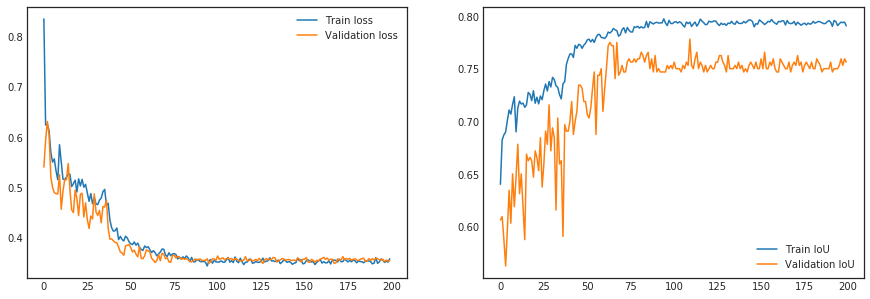

In [24]:
fig, (ax_loss, ax_iou) = plt.subplots(1, 2, figsize=(15, 5))
ax_loss.plot(lovasz_history["epoch"], lovasz_history["train_loss"], label="Train loss")
ax_loss.plot(
    lovasz_history["epoch"], lovasz_history["val_loss"], label="Validation loss"
)
ax_loss.legend()
ax_iou.plot(lovasz_history["epoch"], lovasz_history["train_iou"], label="Train IoU")
ax_iou.plot(lovasz_history["epoch"], lovasz_history["val_iou"], label="Validation IoU")
ax_iou.legend()

### Find Optimal Threshold

In [25]:
filename = os.path.join(model_dir, best_model_filename)
checkpoint = torch.load(filename)
model.load_state_dict(checkpoint["state_dict"])

In [ ]:
model.eval()
predictions = [predict_tta(model, image) for image, _ in tqdm(val_data_loader)]
preds_valid = np.concatenate(predictions, axis=0).squeeze()

preds_thresh_iter = map(
    lambda pred: np.array(np.round(pred > 0), dtype=np.float32), preds_valid
)

preds_thresh = np.array(list(preds_thresh_iter))


plot_predictions(
    train_df, preds_thresh, ids_valid, max_images=15, grid_width=5, figsize=(16, 10)
)

In [27]:
## Scoring for last model, choose threshold using validation data
thresholds = np.linspace(0.3, 0.7, 31)
y_valid_down = y_valid.squeeze()
thresholds = np.log(thresholds / (1 - thresholds))

ious = list(
    map(
        lambda th: iou_metric_batch(y_valid_down, np.int32(preds_valid > th)),
        tqdm(thresholds),
    )
)

threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


Text(0.5, 1.0, 'Threshold vs IoU (0.32277339226305085, 0.82375)')

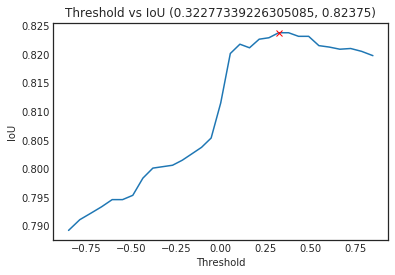

In [28]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))

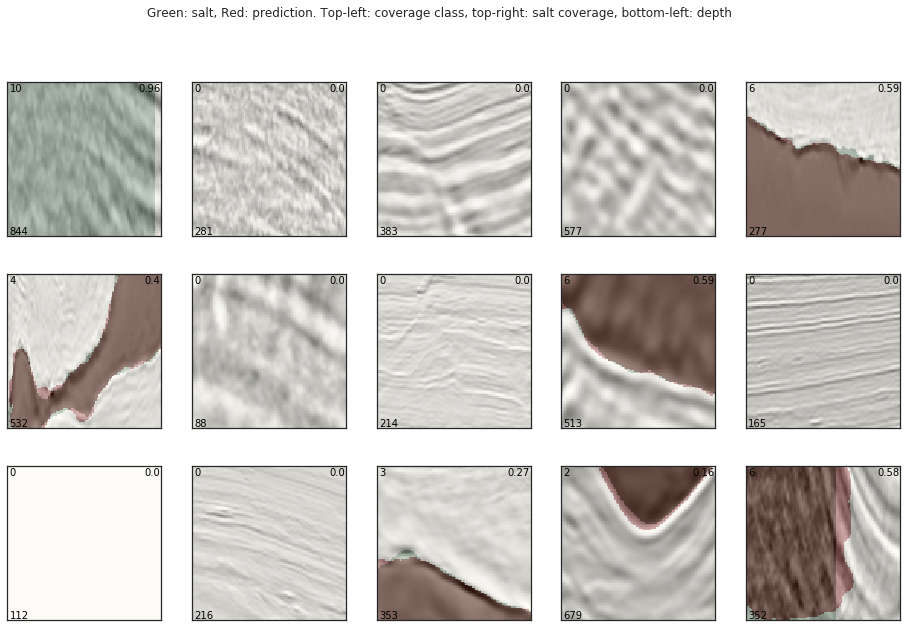

In [29]:
preds_thresh_iter = map(
    lambda pred: np.array(np.round(pred > threshold_best), dtype=np.float32),
    preds_valid,
)
preds_thresh = np.array(list(preds_thresh_iter))

plot_predictions(
    train_df, preds_thresh, ids_valid, max_images=15, grid_width=5, figsize=(16, 10)
)

plt.legend()

In [ ]:
plot_poor_predictions(
    train_df,
    preds_thresh,
    y_valid_down,
    ids_valid,
    max_images=15,
    grid_width=5,
    figsize=(16, 10),
)

In [31]:
dd = train_df.loc[ids_valid]

In [ ]:
dd.groupby("coverage_class").mean().iou.plot(kind="bar")

In [ ]:
dd.groupby("coverage_class").count().z.plot(kind="bar")

In [ ]:
dd["iou"].mean()

In [ ]:
# write best threshold to config
config = load_config()
config["EvaluateModel"]["threshold"] = threshold_best
save_config(config)